# ImageNet Baseline - Simple ResNet

This notebook implements a simple baseline on ImageNet using a ResNet architecture.


In [1]:
# Global preparations
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:6'
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


PyTorch version: 2.1.2+cu121
Device: cuda:6


## Data Loading

ImageNet dataset loading with standard augmentations for training and validation.


In [44]:
# ImageNet data paths (adjust these to your ImageNet location)
imagenet_train_path = '/path/to/imagenet/train'  # Update this path
imagenet_val_path = '/path/to/imagenet/val'      # Update this path

# Standard ImageNet normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    normalize,
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# Note: You need to have ImageNet dataset downloaded
# For demonstration, we'll use ImageNet-like dataset or CIFAR-100 as a proxy
# Uncomment and update paths when you have ImageNet available
"""
train_dataset = torchvision.datasets.ImageFolder(
    root=imagenet_train_path,
    transform=train_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    root=imagenet_val_path,
    transform=val_transform
)
"""

# Using CIFAR-100 as a smaller proxy for testing (same structure as ImageNet)
# Replace with ImageNet when available
print("Using CIFAR-100 as a proxy dataset. Replace with ImageNet for full experiments.")

train_transform_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

val_transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])


train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_cifar
)

val_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=val_transform_cifar
)

batch_size = 32
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")


Using CIFAR-100 as a proxy dataset. Replace with ImageNet for full experiments.
Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000
Val dataset size: 10000
Number of classes: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


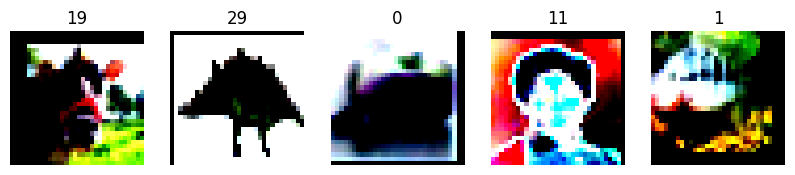

In [45]:
# visualise few samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.title(train_dataset[i][1])
    plt.axis('off')

## Baseline Model

We'll use ResNet18 as a simple baseline. This can be easily replaced with ResNet50 or other architectures.


In [25]:
# Load pre-trained ResNet18 and modify for our dataset
# For CIFAR-100, we'll modify the first conv layer to handle 32x32 images
# For ImageNet (224x224), use standard ResNet18

num_classes = len(train_dataset.classes)

if hasattr(train_dataset, 'classes'):
    # CIFAR-100 or similar small dataset
    model = torchvision.models.resnet18(weights=None)  # Start from scratch
    # Modify first conv layer for smaller input
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove maxpool for smaller images
    model.fc = nn.Linear(model.fc.in_features, num_classes)
else:
    # ImageNet
    model = torchvision.models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: ResNet18")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of classes: {num_classes}")


Model: ResNet18
Total parameters: 11,220,132
Trainable parameters: 11,220,132
Number of classes: 100


## ViT baseline

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def causal_mask(L: int, device):
    # attn_mask: True = block attention (PyTorch MHA supports bool masks)
    return torch.triu(torch.ones(L, L, device=device, dtype=torch.bool), diagonal=1)


class CausalTransformerBlock(nn.Module):
    def __init__(self, dim=256, heads=8, mlp_dim=1024, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, attn_mask):
        y, _ = self.attn(self.ln1(x), self.ln1(x), self.ln1(x), attn_mask=attn_mask, need_weights=False)
        x = x + y
        x = x + self.mlp(self.ln2(x))
        return x


class CIFAR100_CausalJEPA_ViT(nn.Module):
    """
    32x32x3 -> 4x4 patches => 8x8=64 tokens, embed=256
    Append CLS token at the end => sequence length 65
    6 causal attention layers
    Internal AR JEPA-like loss: predict next embedding (MSE) using stop-grad target
    CLS -> num_classes=100
    """
    def __init__(
        self,
        image_size=32,
        patch_size=4,
        in_chans=3,
        dim=256,
        depth=6,
        heads=4,
        mlp_dim=512,
        dropout=0.1,
        num_classes=100,
    ):
        super().__init__()
        assert image_size == 32 and patch_size == 4
        self.image_size = image_size
        self.patch_size = patch_size
        self.dim = dim

        self.grid = image_size // patch_size  # 8
        self.n_patches = self.grid * self.grid  # 64
        self.seq_len = self.n_patches + 1  # + CLS at end

        patch_dim = in_chans * patch_size * patch_size  # 3*4*4=48
        self.patch_to_emb = nn.Linear(patch_dim, dim)

        # learned positional encodings for 64 patches + CLS
        self.pos = nn.Parameter(torch.zeros(1, self.seq_len, dim))
        nn.init.trunc_normal_(self.pos, std=0.02)

        self.cls = nn.Parameter(torch.zeros(1, 1, dim))
        nn.init.trunc_normal_(self.cls, std=0.02)

        self.drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            CausalTransformerBlock(dim=dim, heads=heads, mlp_dim=mlp_dim, dropout=dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

        # Predictor for next-embedding regression (JEPA-like, internal)
        self.pred_next = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
        )

        self.head = nn.Linear(dim, num_classes)

    def patchify(self, x):
        # x: (B,3,32,32) -> (B,64,48)
        B, C, H, W = x.shape
        P = self.patch_size
        x = x.unfold(2, P, P).unfold(3, P, P)            # (B,C,8,8,P,P)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()     # (B,8,8,C,P,P)
        x = x.view(B, self.n_patches, C * P * P)         # (B,64,48)
        return x

    def forward(self, x, targets=None, mse_weight=1.0, ce_weight=1.0):
        """
        If targets is provided (class labels), returns:
          logits, total_loss, mse_loss, ce_loss
        Else returns:
          logits, mse_loss
        """
        B = x.size(0)
        device = x.device

        patches = self.patchify(x)                       # (B,64,48)
        tok = self.patch_to_emb(patches)                 # (B,64,256)

        cls = self.cls.expand(B, 1, self.dim)            # (B,1,256) appended at end
        seq = torch.cat([tok, cls], dim=1)               # (B,65,256)
        h0 = seq + self.pos[:, : seq.size(1)]
        seq = self.drop(h0)

        attn_mask = causal_mask(seq.size(1), device=device)

        h = seq
        for blk in self.blocks:
            h = blk(h, attn_mask=attn_mask)
        h = self.norm(h)                                 # (B,65,256)

        # Classification from CLS at end
        cls_h = h[:, -1, :]                               # (B,256)
        logits = self.head(cls_h)                         # (B,100)

        # JEPA-like internal AR MSE: predict h[t+1] from h[t], stop-grad target
        # We exclude the last position (no next token). This includes predicting CLS from last patch.
        pred = self.pred_next(h[:, :-1, :])               # (B,64,256)
        tgt = h0[:, 1:, :].detach()                        # (B,64,256)
        mse_loss = F.mse_loss(pred, tgt)

        if targets is None:
            return logits, mse_loss

        ce_loss = F.cross_entropy(logits, targets)
        total = mse_weight * mse_loss + ce_weight * ce_loss
        return logits, total, mse_loss, ce_loss

In [30]:
vit_baseline = CIFAR100_CausalJEPA_ViT()

total_params = sum(p.numel() for p in vit_baseline.parameters())
trainable_params = sum(p.numel() for p in vit_baseline.parameters() if p.requires_grad)

print(f"Baseline ViT Model")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of classes: {len(train_dataset.classes)}")


Baseline ViT Model
Total parameters: 3,284,580
Trainable parameters: 3,284,580
Number of classes: 100


## Training Setup

Define loss function, optimizer, and learning rate scheduler.


In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [37]:
import torch

def train_one_epoch(
    model, loader, optimizer, device,
    mse_weight=1.0, ce_weight=1.0
):
    model.train()
    total_loss = total_ce = total_mse = 0.0
    correct = n = 0

    pbar = tqdm(loader, desc="train", leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits, loss, mse, ce = model(
            x, targets=y,
            mse_weight=mse_weight,
            ce_weight=ce_weight
        )
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_ce += ce.item() * bs
        total_mse += mse.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        n += bs

        pbar.set_postfix(
            loss=total_loss / n,
            acc=correct / n,
        )

    return {
        "loss": total_loss / n,
        "ce": total_ce / n,
        "mse": total_mse / n,
        "acc": correct / n,
    }


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = n = 0

    pbar = tqdm(loader, desc="val", leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits, _ = model(x, targets=None)
        ce = torch.nn.functional.cross_entropy(logits, y)

        bs = x.size(0)
        total_loss += ce.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        n += bs

        pbar.set_postfix(
            loss=total_loss / n,
            acc=correct / n,
        )

    return {
        "loss": total_loss / n,
        "acc": correct / n,
    }


# -------- main loop with history --------
vit_baseline = vit_baseline.to(device)
epochs=100

optimizer = torch.optim.AdamW(
    vit_baseline.parameters(),
    lr=1e-4,
    weight_decay=0.05
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=epochs
)

for epoch in range(epochs):
    print(f"\nEpoch {epoch:03d}")

    train_stats = train_one_epoch(
        vit_baseline,
        train_loader,
        optimizer,
        device,
        mse_weight=0.1,
        ce_weight=1.0,
    )
    val_stats = evaluate(
        vit_baseline,
        val_loader,
        device,
    )

    scheduler.step()

    train_losses.append(train_stats["loss"])
    val_losses.append(val_stats["loss"])
    train_accs.append(train_stats["acc"])
    val_accs.append(val_stats["acc"])

    print(
        f"train loss {train_stats['loss']:.4f} | "
        f"val loss {val_stats['loss']:.4f} | "
        f"train acc {train_stats['acc']:.3f} | "
        f"val acc {val_stats['acc']:.3f}"
    )



Epoch 000


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3216 | val loss 1.6914 | train acc 0.906 | val acc 0.643

Epoch 001


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3286 | val loss 1.7078 | train acc 0.905 | val acc 0.636

Epoch 002


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3382 | val loss 1.7137 | train acc 0.901 | val acc 0.635

Epoch 003


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3392 | val loss 1.7045 | train acc 0.900 | val acc 0.640

Epoch 004


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3426 | val loss 1.7088 | train acc 0.900 | val acc 0.638

Epoch 005


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3441 | val loss 1.6873 | train acc 0.899 | val acc 0.638

Epoch 006


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3408 | val loss 1.7130 | train acc 0.900 | val acc 0.637

Epoch 007


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3414 | val loss 1.7041 | train acc 0.901 | val acc 0.639

Epoch 008


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3447 | val loss 1.7070 | train acc 0.898 | val acc 0.636

Epoch 009


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3385 | val loss 1.7009 | train acc 0.901 | val acc 0.640

Epoch 010


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3401 | val loss 1.7024 | train acc 0.900 | val acc 0.638

Epoch 011


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3330 | val loss 1.7071 | train acc 0.903 | val acc 0.641

Epoch 012


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3394 | val loss 1.7114 | train acc 0.900 | val acc 0.636

Epoch 013


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3250 | val loss 1.7117 | train acc 0.904 | val acc 0.637

Epoch 014


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3375 | val loss 1.6963 | train acc 0.902 | val acc 0.641

Epoch 015


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3346 | val loss 1.6883 | train acc 0.904 | val acc 0.637

Epoch 016


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3375 | val loss 1.6837 | train acc 0.901 | val acc 0.641

Epoch 017


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3316 | val loss 1.6773 | train acc 0.902 | val acc 0.641

Epoch 018


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3372 | val loss 1.7001 | train acc 0.902 | val acc 0.637

Epoch 019


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3226 | val loss 1.6809 | train acc 0.905 | val acc 0.642

Epoch 020


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3220 | val loss 1.6839 | train acc 0.905 | val acc 0.644

Epoch 021


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3205 | val loss 1.6892 | train acc 0.907 | val acc 0.643

Epoch 022


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3198 | val loss 1.6921 | train acc 0.907 | val acc 0.645

Epoch 023


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3206 | val loss 1.7058 | train acc 0.906 | val acc 0.638

Epoch 024


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3183 | val loss 1.6958 | train acc 0.906 | val acc 0.640

Epoch 025


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3226 | val loss 1.7091 | train acc 0.905 | val acc 0.642

Epoch 026


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3160 | val loss 1.6867 | train acc 0.910 | val acc 0.642

Epoch 027


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3129 | val loss 1.6930 | train acc 0.907 | val acc 0.643

Epoch 028


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3148 | val loss 1.6857 | train acc 0.908 | val acc 0.641

Epoch 029


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3067 | val loss 1.6994 | train acc 0.910 | val acc 0.643

Epoch 030


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3096 | val loss 1.6644 | train acc 0.909 | val acc 0.646

Epoch 031


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3057 | val loss 1.6870 | train acc 0.912 | val acc 0.642

Epoch 032


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3032 | val loss 1.6942 | train acc 0.912 | val acc 0.640

Epoch 033


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.3037 | val loss 1.6813 | train acc 0.911 | val acc 0.648

Epoch 034


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2991 | val loss 1.7032 | train acc 0.913 | val acc 0.644

Epoch 035


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2961 | val loss 1.6583 | train acc 0.914 | val acc 0.645

Epoch 036


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2908 | val loss 1.6786 | train acc 0.916 | val acc 0.645

Epoch 037


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2947 | val loss 1.6754 | train acc 0.915 | val acc 0.645

Epoch 038


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2859 | val loss 1.6651 | train acc 0.919 | val acc 0.645

Epoch 039


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2884 | val loss 1.6960 | train acc 0.915 | val acc 0.643

Epoch 040


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2898 | val loss 1.6757 | train acc 0.916 | val acc 0.643

Epoch 041


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2792 | val loss 1.6869 | train acc 0.919 | val acc 0.645

Epoch 042


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2775 | val loss 1.6825 | train acc 0.920 | val acc 0.644

Epoch 043


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2732 | val loss 1.6798 | train acc 0.921 | val acc 0.649

Epoch 044


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2749 | val loss 1.6793 | train acc 0.921 | val acc 0.649

Epoch 045


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2695 | val loss 1.6833 | train acc 0.922 | val acc 0.650

Epoch 046


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2717 | val loss 1.6818 | train acc 0.921 | val acc 0.648

Epoch 047


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2655 | val loss 1.6655 | train acc 0.924 | val acc 0.649

Epoch 048


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2594 | val loss 1.6868 | train acc 0.925 | val acc 0.647

Epoch 049


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2581 | val loss 1.7031 | train acc 0.925 | val acc 0.644

Epoch 050


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2607 | val loss 1.6643 | train acc 0.925 | val acc 0.645

Epoch 051


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2591 | val loss 1.6816 | train acc 0.926 | val acc 0.647

Epoch 052


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2533 | val loss 1.6866 | train acc 0.926 | val acc 0.646

Epoch 053


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2491 | val loss 1.6864 | train acc 0.930 | val acc 0.645

Epoch 054


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2539 | val loss 1.6802 | train acc 0.927 | val acc 0.647

Epoch 055


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2467 | val loss 1.6800 | train acc 0.929 | val acc 0.646

Epoch 056


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2400 | val loss 1.6733 | train acc 0.932 | val acc 0.647

Epoch 057


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2448 | val loss 1.6784 | train acc 0.929 | val acc 0.642

Epoch 058


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2367 | val loss 1.6854 | train acc 0.932 | val acc 0.646

Epoch 059


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2352 | val loss 1.6764 | train acc 0.933 | val acc 0.646

Epoch 060


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2426 | val loss 1.6797 | train acc 0.930 | val acc 0.646

Epoch 061


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2353 | val loss 1.6928 | train acc 0.932 | val acc 0.646

Epoch 062


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2335 | val loss 1.6821 | train acc 0.934 | val acc 0.647

Epoch 063


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2308 | val loss 1.6801 | train acc 0.934 | val acc 0.652

Epoch 064


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2250 | val loss 1.6744 | train acc 0.936 | val acc 0.651

Epoch 065


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2253 | val loss 1.6809 | train acc 0.935 | val acc 0.648

Epoch 066


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2206 | val loss 1.6766 | train acc 0.937 | val acc 0.648

Epoch 067


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2201 | val loss 1.6780 | train acc 0.936 | val acc 0.649

Epoch 068


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2207 | val loss 1.6798 | train acc 0.938 | val acc 0.649

Epoch 069


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2161 | val loss 1.6866 | train acc 0.938 | val acc 0.649

Epoch 070


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2167 | val loss 1.6740 | train acc 0.938 | val acc 0.651

Epoch 071


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2178 | val loss 1.6771 | train acc 0.938 | val acc 0.648

Epoch 072


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2173 | val loss 1.6751 | train acc 0.938 | val acc 0.649

Epoch 073


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2134 | val loss 1.6746 | train acc 0.939 | val acc 0.648

Epoch 074


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2127 | val loss 1.6679 | train acc 0.939 | val acc 0.650

Epoch 075


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2088 | val loss 1.6784 | train acc 0.940 | val acc 0.652

Epoch 076


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2059 | val loss 1.6746 | train acc 0.942 | val acc 0.650

Epoch 077


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2054 | val loss 1.6753 | train acc 0.942 | val acc 0.652

Epoch 078


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2002 | val loss 1.6720 | train acc 0.943 | val acc 0.653

Epoch 079


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2112 | val loss 1.6639 | train acc 0.939 | val acc 0.652

Epoch 080


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2075 | val loss 1.6701 | train acc 0.941 | val acc 0.653

Epoch 081


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2006 | val loss 1.6775 | train acc 0.944 | val acc 0.651

Epoch 082


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1984 | val loss 1.6694 | train acc 0.944 | val acc 0.652

Epoch 083


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1975 | val loss 1.6676 | train acc 0.945 | val acc 0.654

Epoch 084


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1926 | val loss 1.6658 | train acc 0.945 | val acc 0.652

Epoch 085


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1884 | val loss 1.6693 | train acc 0.946 | val acc 0.653

Epoch 086


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.2005 | val loss 1.6679 | train acc 0.943 | val acc 0.654

Epoch 087


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1961 | val loss 1.6597 | train acc 0.944 | val acc 0.654

Epoch 088


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1942 | val loss 1.6658 | train acc 0.945 | val acc 0.655

Epoch 089


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1955 | val loss 1.6664 | train acc 0.945 | val acc 0.655

Epoch 090


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1950 | val loss 1.6688 | train acc 0.945 | val acc 0.653

Epoch 091


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1975 | val loss 1.6649 | train acc 0.944 | val acc 0.653

Epoch 092


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1899 | val loss 1.6664 | train acc 0.946 | val acc 0.654

Epoch 093


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1950 | val loss 1.6670 | train acc 0.946 | val acc 0.654

Epoch 094


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1923 | val loss 1.6663 | train acc 0.946 | val acc 0.654

Epoch 095


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1893 | val loss 1.6648 | train acc 0.947 | val acc 0.654

Epoch 096


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1908 | val loss 1.6653 | train acc 0.947 | val acc 0.654

Epoch 097


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1913 | val loss 1.6649 | train acc 0.946 | val acc 0.654

Epoch 098


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1913 | val loss 1.6649 | train acc 0.946 | val acc 0.654

Epoch 099


train:   0%|          | 0/391 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train loss 0.1929 | val loss 1.6649 | train acc 0.945 | val acc 0.654


## Plot Results


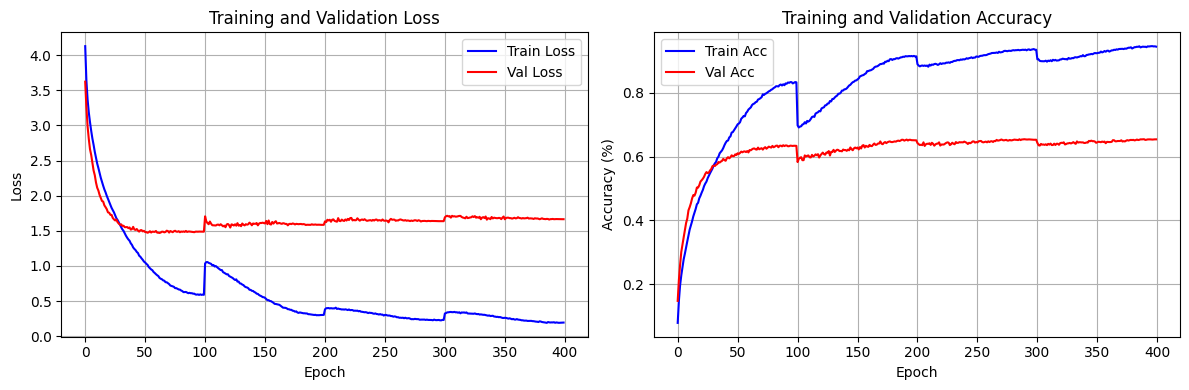

Best validation accuracy: 0.65% at epoch 290


In [38]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', color='blue')
ax2.plot(val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_accs):.2f}% at epoch {val_accs.index(max(val_accs))+1}")


## LUT-based Vision Transformer (LUTViT)

Adapting SimpleViT to use LUT layers similar to LUTTransformer.


In [46]:
# Import LUTNet components
import sys
import os
sys.path.insert(0, os.path.expanduser('~/spiky'))

from spiky.lut.LUTLayer import (
    Conv2DLUTLayer, LUTLayer, LUTSharedContext, SynapseMeta, GradientPolicy, GradientType
)
from spiky.util.torch_utils import make_lr_getter

# Setup LUTNet shared context and metadata
summation_dtype = torch.float32

synapse_meta = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

shared_lut_ctx = LUTSharedContext()
shared_lut_ctx.to_device(device)
g_policy = GradientPolicy(GradientType.Internal, normalized=False)

print("LUTNet components initialized")

LUTNet components initialized


In [83]:
# LUT-based Vision Transformer adapted from SimpleViT
class LUTViT(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_chans=3,
                 num_classes=100, dim=32, depth=6, num_heads=8, 
                 n_detectors=128, n_anchors_per_detector=10, 
                 n_anchors_per_detector_attention=None,
                 dropout=0.1, use_batch_norm=False,
                 device=None, _synapse_meta=None, 
                 lut_shared_context=None, seed=None, 
                 summation_dtype=torch.float32):
        super().__init__()
        
        assert image_size % patch_size == 0
        n_patches = (image_size // patch_size) ** 2
        patch_dim = in_chans * patch_size * patch_size
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.n_patches = n_patches
        self.dim = dim
        self.depth = depth
        self.num_heads = num_heads
        
        if device is None:
            device = torch.device('cpu')
        self.device = device
        
        if _synapse_meta is None:
            _synapse_meta = SynapseMeta(
                min_weight=-1.0,
                max_weight=1.0,
                initial_weight=0.0,
                initial_noise_level=0.0
            )
        
        if lut_shared_context is None:
            lut_shared_context = LUTSharedContext()
            lut_shared_context.to_device(device)
        
        self.lut_shared_context = lut_shared_context
        self.weights_gradient_policy = g_policy
        
        # Patch embedding: linear layer to embed patches
        self.patch_to_emb = nn.Linear(patch_dim, dim, device=device)
        
        # CLS token and positional embeddings
        self.cls = nn.Parameter(torch.zeros(1, 1, dim, device=device))
        self.pos_drop = nn.Dropout(dropout)
        
        # Initialize CLS and positional embeddings
        nn.init.trunc_normal_(self.cls, std=0.02)
        
        # Transformer blocks
        self.blocks = nn.ModuleList()
        n_anchors_attn = n_anchors_per_detector_attention if n_anchors_per_detector_attention is not None else n_anchors_per_detector
        
        for layer_idx in range(depth):
            block = nn.ModuleDict()
            
            # Multi-head attention using LUTLayer
            # Use a single LUTLayer for attention (similar to LUTTransformer)
            # The LUTLayer processes the sequence with sequence_length = 1 + n_patches
            block['attention_lut'] = LUTLayer(
                n_inputs=dim,
                n_outputs=dim,
                positional_dim=dim,
                unified_pe=False,
                concatenation_product=False,
                sliced_product_mode=True,
                n_detectors=n_detectors * num_heads,  # Scale detectors for multi-head capacity
                n_anchors_per_detector=n_anchors_attn,
                sequence_length=1 + n_patches,  # CLS + patches
                synapse_meta=_synapse_meta,
                weights_gradient_policy=self.weights_gradient_policy,
                shared_context=self.lut_shared_context,
                summation_dtype=summation_dtype,
                random_seed=None if seed is None else seed + layer_idx * num_heads,
                device=device
            )
            block['attention_dropout'] = nn.Dropout(dropout)
            
            if use_batch_norm:
                block['attention_bn'] = nn.BatchNorm1d(dim, device=device)
            else:
                block['attention_bn'] = None
            
            # FFN using LUTLayer
            # FFN processes each token independently (sequence_length=1)
            block['ffn'] = LUTLayer(
                n_inputs=dim,
                n_outputs=dim,
                n_detectors=n_detectors,
                n_anchors_per_detector=n_anchors_per_detector,
                sequence_length=1,  # Process tokens independently
                synapse_meta=_synapse_meta,
                weights_gradient_policy=self.weights_gradient_policy,
                shared_context=self.lut_shared_context,
                summation_dtype=summation_dtype,
                random_seed=None if seed is None else seed + layer_idx * num_heads + num_heads,
                device=device
            )
            block['ffn_dropout'] = nn.Dropout(dropout)
            
            if use_batch_norm:
                block['ffn_bn'] = nn.BatchNorm1d(dim, device=device)
            else:
                block['ffn_bn'] = None
            
            self.blocks.append(block)
        
        self.head = LUTLayer(
            n_inputs=dim,
            n_outputs=dim,
            n_detectors=n_detectors,
            n_anchors_per_detector=n_anchors_per_detector,
            sequence_length=1,
            synapse_meta=_synapse_meta,
            weights_gradient_policy=self.weights_gradient_policy,
            shared_context=self.lut_shared_context,
            summation_dtype=summation_dtype,
            random_seed=seed,
            device=device
        )
        
        self.final_classifier = LUTLayer(
            n_inputs=dim,
            n_outputs=num_classes,
            n_detectors=n_detectors,
            n_anchors_per_detector=n_anchors_per_detector,
            sequence_length=1,
            synapse_meta=_synapse_meta,
            weights_gradient_policy=self.weights_gradient_policy,
            shared_context=self.lut_shared_context,
            summation_dtype=summation_dtype,
            random_seed=seed,
            device=device
        )

    def forward(self, x):
        B, C, H, W = x.shape
        P = self.patch_size
        
        # Patch embedding: (B, C, H, W) -> (B, N, patch_dim) -> (B, N, dim)
        x = x.unfold(2, P, P).unfold(3, P, P)  # (B, C, Hp, Wp, P, P)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()  # (B, Hp, Wp, C, P, P)
        x = x.view(B, -1, C * P * P)  # (B, N, patch_dim)
        x = self.patch_to_emb(x)  # (B, N, dim)
        source_seq = x
        
        # Add CLS token
        cls_token = self.cls.expand(B, -1, -1)  # (B, 1, dim)
        x = torch.cat([x, cls_token], dim=1)  # (B, 1+N, dim)
        x = self.pos_drop(x)
        
        non_seq_shape = (B * (1 + self.n_patches), 1, self.dim)
        seq_shape = (B, 1 + self.n_patches, self.dim)
        
        # Transformer blocks
        for block in self.blocks:
            residual = x
            
            # Multi-head attention using LUTLayer
            # LUTLayer processes sequence: (B, 1+N, dim) -> (B, 1+N, dim)
            # The sequence_length=1+N means it processes the whole sequence
            attn_out = block['attention_lut'](x)  # (B, 1+N, dim)
            attn_out = block['attention_dropout'](attn_out)
            
            if block['attention_bn'] is not None:
                # BatchNorm: (B, 1+N, dim) -> (B*(1+N), dim) -> (B, 1+N, dim)
                attn_out_flat = attn_out.reshape(-1, self.dim)
                attn_out_flat = block['attention_bn'](attn_out_flat)
                attn_out = attn_out_flat.reshape(B, 1 + self.n_patches, self.dim)
            
            x = residual + attn_out  # Residual connection
            
            # FFN with residual connection
            residual = x
            # Reshape for FFN: (B, 1+N, dim) -> (B*(1+N), 1, dim) for sequence_length=1
            ffn_out = block['ffn'](x.reshape(non_seq_shape))  # (B*(1+N), 1, dim)
            ffn_out = ffn_out.reshape(seq_shape)  # (B, 1+N, dim)
            ffn_out = block['ffn_dropout'](ffn_out)
            
            if block['ffn_bn'] is not None:
                # BatchNorm: (B, 1+N, dim) -> (B*(1+N), dim) -> (B, 1+N, dim)
                ffn_out_flat = ffn_out.reshape(-1, self.dim)
                ffn_out_flat = block['ffn_bn'](ffn_out_flat)
                ffn_out = ffn_out_flat.reshape(B, 1 + self.n_patches, self.dim)
            
            x = residual + ffn_out  # Residual connection
        
        patch_logits = self.head(x.reshape(non_seq_shape)).reshape(seq_shape)
        self.internal_loss = F.mse_loss(source_seq[:,1:,:], patch_logits[:,:-2,:])
        
        return self.final_classifier(patch_logits[:, -1:, :].contiguous()).squeeze(1)
    
    def set_external_learning_rate_hook(self, lr_hook):
        """Set learning rate hooks for all LUT layers"""
        for block in self.blocks:
            block['attention_lut'].set_external_learning_rate_hook(lr_hook)
            block['ffn'].set_external_learning_rate_hook(lr_hook)
        self.head.set_external_learning_rate_hook(lr_hook)
        self.final_classifier.set_external_learning_rate_hook(lr_hook)


In [84]:
# Create LUTViT model for CIFAR-10
lut_vit = LUTViT(
    image_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=len(train_dataset.classes),
    dim=128,
    depth=6,
    num_heads=4,
    n_detectors=16,
    n_anchors_per_detector=10,
    n_anchors_per_detector_attention=8,
    dropout=0.1,
    use_batch_norm=False,
    device=device,
    _synapse_meta=synapse_meta,
    lut_shared_context=shared_lut_ctx,
    seed=random_seed,
    summation_dtype=summation_dtype
)

lut_vit = lut_vit.to(device)

# Count parameters
lut_vit_total_params = sum(p.numel() for p in lut_vit.parameters())
lut_vit_trainable_params = sum(p.numel() for p in lut_vit.parameters() if p.requires_grad)

print(f"LUTViT Model")
print(f"Total parameters: {lut_vit_total_params:,}")
print(f"Trainable parameters: {lut_vit_trainable_params:,}")
print(f"Number of classes: {len(train_dataset.classes)}")


LUTViT Model
Total parameters: 32,053,504
Trainable parameters: 32,053,504
Number of classes: 100


In [85]:
from torch.optim.lr_scheduler import LambdaLR
from spiky.util.torch_utils import make_lr_getter
# Setup optimizer for LUTViT
lr = 0.001
lut_vit_optimizer = torch.optim.SGD(
    lut_vit.parameters(),
    lr=lr,
    #momentum=0.9,
    #weight_decay=1e-4
)

# lut_vit_sched = torch.optim.lr_scheduler.StepLR(
#     lut_vit_optimizer,
#     step_size=30,
#     gamma=0.1
# )

def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

lut_vit_sched = None
#lut_vit_sched = LambdaLR(lut_vit_optimizer, lr_lambda=lr_func)
#lut_net.setup_external_learning_rate_hook(lut_optimizer)

# Set up learning rate hooks for LUT layers
lut_vit_lr_getter = make_lr_getter(lut_vit_optimizer)
lut_vit.set_external_learning_rate_hook(lut_vit_lr_getter)

In [86]:
# Training functions for LUTNet
def train_one_epoch_lut(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = model.internal_loss + criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            for _ in range(inputs.shape[0]):
                scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_description(
            f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%, '
            f'lr: {scheduler.get_last_lr()[0] if scheduler is not None else lr:.4f}'
        )
    
    # scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate_lut(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

## LUTViT Training Loop


In [87]:
lut_vit_criterion = nn.CrossEntropyLoss()

lut_vit_train_losses = []
lut_vit_train_accs = []
lut_vit_val_losses = []
lut_vit_val_accs = []

In [ ]:
# LUTViT training
lut_vit_num_epochs = 100

print(f"Starting LUTViT training for {lut_vit_num_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Device: {device}\n")

for epoch in range(lut_vit_num_epochs):
    print(f'LUTViT Epoch {epoch+1}/{lut_vit_num_epochs}')
    print(f'Learning rate: {lut_vit_sched.get_last_lr()[0] if lut_vit_sched is not None else lr:.6f}')
    
    # Train
    train_loss, train_acc = train_one_epoch_lut(
        lut_vit, train_loader, lut_vit_criterion, lut_vit_optimizer, lut_vit_sched, device
    )
    lut_vit_train_losses.append(train_loss)
    lut_vit_train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate_lut(lut_vit, val_loader, lut_vit_criterion, device)
    lut_vit_val_losses.append(val_loss)
    lut_vit_val_accs.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)


Starting LUTViT training for 100 epochs...
Batch size: 32
Device: cuda:6

LUTViT Epoch 1/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.8586, Train Acc: 0.96%
Val Loss: 4.6050, Val Acc: 1.02%
------------------------------------------------------------
LUTViT Epoch 2/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.7279, Train Acc: 0.89%
Val Loss: 4.6052, Val Acc: 1.00%
------------------------------------------------------------
LUTViT Epoch 3/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.7047, Train Acc: 0.93%
Val Loss: 4.6052, Val Acc: 1.00%
------------------------------------------------------------
LUTViT Epoch 4/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6931, Train Acc: 0.89%
Val Loss: 4.6052, Val Acc: 1.21%
------------------------------------------------------------
LUTViT Epoch 5/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6846, Train Acc: 0.81%
Val Loss: 4.6052, Val Acc: 1.00%
------------------------------------------------------------
LUTViT Epoch 6/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6774, Train Acc: 0.91%
Val Loss: 4.6052, Val Acc: 0.79%
------------------------------------------------------------
LUTViT Epoch 7/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6715, Train Acc: 0.89%
Val Loss: 4.6051, Val Acc: 1.00%
------------------------------------------------------------
LUTViT Epoch 8/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6661, Train Acc: 0.98%
Val Loss: 4.6052, Val Acc: 1.00%
------------------------------------------------------------
LUTViT Epoch 9/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6615, Train Acc: 0.97%
Val Loss: 4.6040, Val Acc: 1.88%
------------------------------------------------------------
LUTViT Epoch 10/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6566, Train Acc: 1.40%
Val Loss: 4.6016, Val Acc: 1.91%
------------------------------------------------------------
LUTViT Epoch 11/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6505, Train Acc: 1.57%
Val Loss: 4.5965, Val Acc: 1.94%
------------------------------------------------------------
LUTViT Epoch 12/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6415, Train Acc: 1.80%
Val Loss: 4.5868, Val Acc: 1.92%
------------------------------------------------------------
LUTViT Epoch 13/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6281, Train Acc: 1.81%
Val Loss: 4.5745, Val Acc: 1.97%
------------------------------------------------------------
LUTViT Epoch 14/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6147, Train Acc: 1.81%
Val Loss: 4.5623, Val Acc: 1.98%
------------------------------------------------------------
LUTViT Epoch 15/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.6024, Train Acc: 1.81%
Val Loss: 4.5506, Val Acc: 1.99%
------------------------------------------------------------
LUTViT Epoch 16/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5907, Train Acc: 1.77%
Val Loss: 4.5396, Val Acc: 1.98%
------------------------------------------------------------
LUTViT Epoch 17/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5799, Train Acc: 1.85%
Val Loss: 4.5296, Val Acc: 1.97%
------------------------------------------------------------
LUTViT Epoch 18/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5701, Train Acc: 1.88%
Val Loss: 4.5204, Val Acc: 1.97%
------------------------------------------------------------
LUTViT Epoch 19/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5621, Train Acc: 1.90%
Val Loss: 4.5172, Val Acc: 1.98%
------------------------------------------------------------
LUTViT Epoch 20/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5534, Train Acc: 1.89%
Val Loss: 4.5051, Val Acc: 1.99%
------------------------------------------------------------
LUTViT Epoch 21/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5468, Train Acc: 1.91%
Val Loss: 4.5010, Val Acc: 2.04%
------------------------------------------------------------
LUTViT Epoch 22/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 4.5392, Train Acc: 1.92%
Val Loss: 4.4892, Val Acc: 2.10%
------------------------------------------------------------
LUTViT Epoch 23/100
Learning rate: 0.001000


  0%|          | 0/1563 [00:00<?, ?it/s]

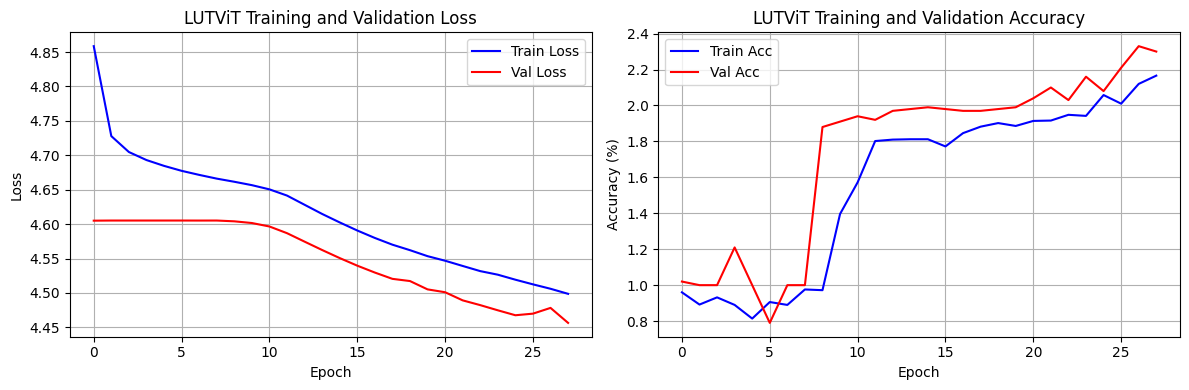

LUTViT Best validation accuracy: 2.33% at epoch 27


In [89]:
# Plot LUTViT training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_vit_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_vit_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTViT Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_vit_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_vit_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTViT Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_vit_val_accs) > 0:
    print(f"LUTViT Best validation accuracy: {max(lut_vit_val_accs):.2f}% at epoch {lut_vit_val_accs.index(max(lut_vit_val_accs))+1}")


## Plot LUTViT Results


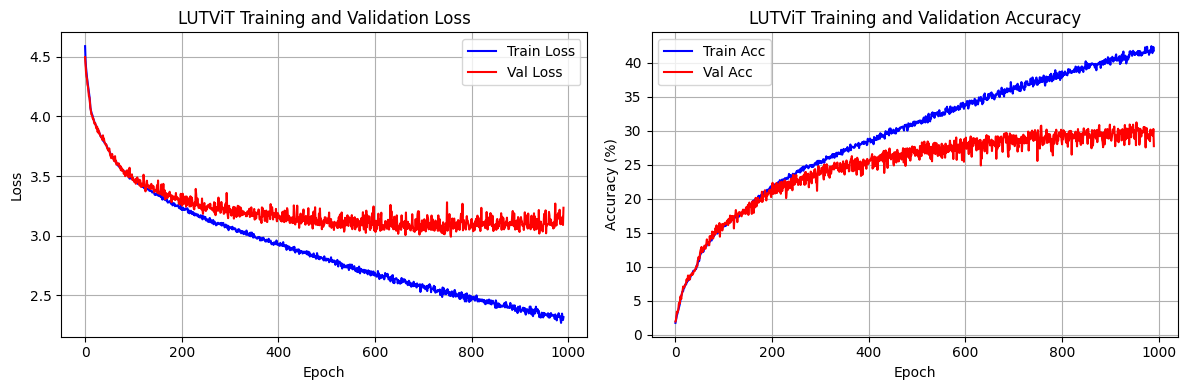

LUTViT Best validation accuracy: 31.25% at epoch 955


In [25]:
# Plot LUTViT training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_vit_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_vit_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTViT Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_vit_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_vit_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTViT Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_vit_val_accs) > 0:
    print(f"LUTViT Best validation accuracy: {max(lut_vit_val_accs):.2f}% at epoch {lut_vit_val_accs.index(max(lut_vit_val_accs))+1}")


In [ ]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dim, mlp_dim, drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(drop),
        )
    def forward(self, x): return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, mlp_dim, drop)

    def forward(self, x):
        y, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), need_weights=False)
        x = x + y
        x = x + self.mlp(self.norm2(x))
        return x

class SimpleViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_chans=3,
                 num_classes=1000, dim=768, depth=12, heads=12, mlp_dim=3072, drop=0.0):
        super().__init__()
        assert image_size % patch_size == 0
        n_patches = (image_size // patch_size) ** 2
        patch_dim = in_chans * patch_size * patch_size

        self.patch_size = patch_size
        self.patch_to_emb = nn.Linear(patch_dim, dim)

        self.cls = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos = nn.Parameter(torch.zeros(1, 1 + n_patches, dim))
        self.pos_drop = nn.Dropout(drop)

        self.blocks = nn.Sequential(*[
            EncoderBlock(dim, heads, mlp_dim, drop) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls, std=0.02)

    def forward(self, x):
        B, C, H, W = x.shape
        P = self.patch_size
        # (B, C, H, W) -> (B, N, patch_dim)
        x = x.unfold(2, P, P).unfold(3, P, P)                # B,C,Hp,Wp,P,P
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()         # B,Hp,Wp,C,P,P
        x = x.view(B, -1, C * P * P)                         # B,N,patch_dim

        x = self.patch_to_emb(x)                             # B,N,D
        cls = self.cls.expand(B, -1, -1)                     # B,1,D
        x = torch.cat([cls, x], dim=1)                       # B,1+N,D
        x = self.pos_drop(x + self.pos[:, : x.size(1)])

        x = self.blocks(x)
        x = self.norm(x)
        return self.head(x[:, 0])                            # CLS


In [19]:
torch.tensor([1,2,3,4])[1:-1]


tensor([2, 3])